

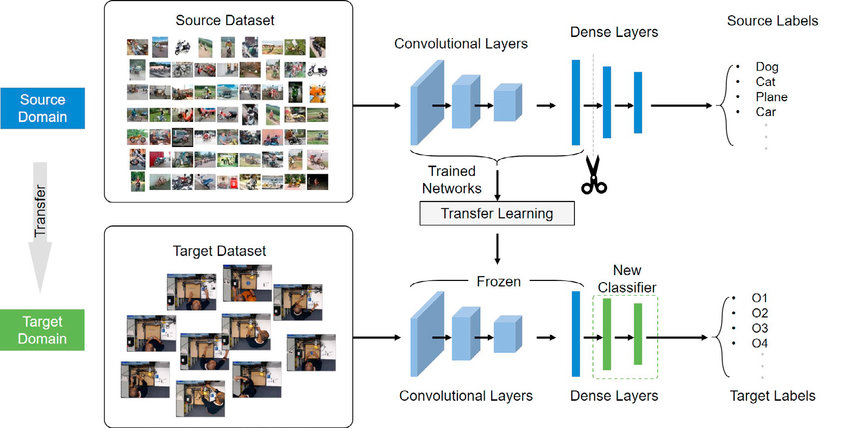

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Examine and understand the data
In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a tf.data.Dataset for training and validation using the tf.keras.utils.image_dataset_from_directory utility. You can learn more about loading images in this tutorial.

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-03-03 13:02:30--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.127.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  26.8MB/s    in 2.4s    

2023-03-03 13:02:33 (26.8 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
!unzip /content/cats_and_dogs_filtered.zip

Archive:  /content/cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/

In [ ]:
train_dir ="/content/cats_and_dogs_filtered/train"
validation_dir = "/content/cats_and_dogs_filtered/validation"

In [ ]:
#Size of the batches of data
BATCH_SIZE = 32
#Size to resize images
IMG_SIZE = (160, 160)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


### Show the first nine images and labels from the training set:

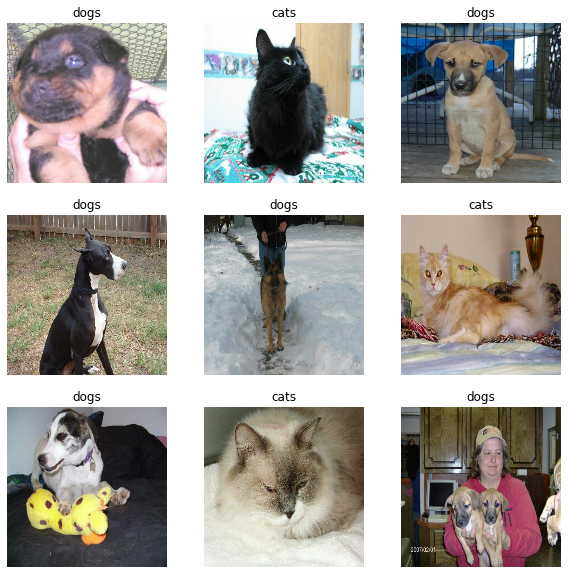

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Split Validation into Validation and test

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of validation batches: 32


In [ ]:
test_dataset = validation_dataset.take(5)
validation_dataset = validation_dataset.skip(5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 27
Number of validation batches: 5


### Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

### Rescale image pixel values
- MobileNetV2 model: Expects pixel values in `[-1, 1]`
- Pixel values in the images are in `[0, 255]`.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Create the base model
- MobileNet V2 model developed at Google.
- pre-trained on the ImageNet dataset, consisting of 1.4M images and 1000 classes.

In [ ]:
IMG_SHAPE = (160,160,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # load the model without the classification layers at the top
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


## Feature Extraction
- Use the representations learned by the pretrained model to extract meaningful features from new samples.

- Add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

### Freeze the convolutional base
Prevents the weights in a given layer from being updated during training

In [ ]:
# Freeze the convolutional base
base_model.trainable = False

In [ ]:
# The base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Feature extractor
- Converts each 160x160x3 image into a 5x5x1280 block of features.

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Convert the features to a single 1280-element vector per image (flatten)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# test it's results
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


### Add a classification head (Predication Layer)
- Convert the features into a single prediction per image.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)

# test it's results
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Build The model
- chaining together the data augmentation, rescaling, base_model and feature extractor layers.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x) # flatten 1-D vector
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model
- Since there are two classes, we will use the ``tf.keras.losses.BinaryCrossentropy`` loss

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

### Train the model

In [ ]:
epochs = 10

In [ ]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/10


63/63 [==============================] - 17s 170ms/step - loss: 0.7746 - accuracy: 0.5375 - val_loss: 0.6128 - val_accuracy: 0.6250
Epoch 2/10
63/63 [==============================] - 9s 147ms/step - loss: 0.5647 - accuracy: 0.6795 - val_loss: 0.4404 - val_accuracy: 0.7679
Epoch 3/10
63/63 [==============================] - 8s 129ms/step - loss: 0.4466 - accuracy: 0.7640 - val_loss: 0.3355 - val_accuracy: 0.8655
Epoch 4/10
63/63 [==============================] - 9s 142ms/step - loss: 0.3723 - accuracy: 0.8325 - val_loss: 0.2704 - val_accuracy: 0.8952
Epoch 5/10
63/63 [==============================] - 9s 143ms/step - loss: 0.3295 - accuracy: 0.8525 - val_loss: 0.2283 - val_accuracy: 0.9060
Epoch 6/10
63/63 [==============================] - 9s 144ms/step - loss: 0.2945 - accuracy: 0.8735 - val_loss: 0.2002 - val_accuracy: 0.9262
Epoch 7/10
63/63 [==============================] - 8s 128ms/step - loss: 0.2780 - accuracy: 0.8825 - val_loss: 0.1793 - val_accuracy: 0.9298
Epoch 8/10
63/63

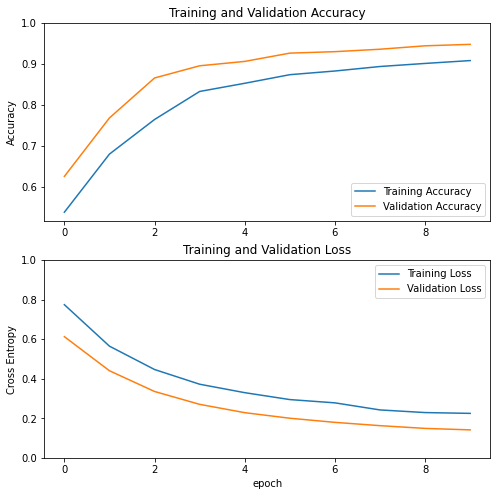

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
- In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

-  To increase performance even further we can fine-tune the weights of the top layers of the pre-trained model.

### Un-freeze the top layers of the model

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Compile the model
As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

### Continue training the model

In [ ]:

fine_tune_epochs = epochs + 10

history_fine = model.fit(train_dataset,
                         epochs=fine_tune_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


63/63 [==============================] - 24s 164ms/step - loss: 0.1736 - accuracy: 0.9300 - val_loss: 0.0622 - val_accuracy: 0.9726
Epoch 11/20
63/63 [==============================] - 10s 155ms/step - loss: 0.1116 - accuracy: 0.9565 - val_loss: 0.0494 - val_accuracy: 0.9810
Epoch 12/20
63/63 [==============================] - 10s 153ms/step - loss: 0.1059 - accuracy: 0.9565 - val_loss: 0.0657 - val_accuracy: 0.9726
Epoch 13/20
63/63 [==============================] - 10s 149ms/step - loss: 0.1001 - accuracy: 0.9585 - val_loss: 0.0460 - val_accuracy: 0.9845
Epoch 14/20
63/63 [==============================] - 9s 142ms/step - loss: 0.0835 - accuracy: 0.9640 - val_loss: 0.0597 - val_accuracy: 0.9726
Epoch 15/20
63/63 [==============================] - 9s 139ms/step - loss: 0.0835 - accuracy: 0.9655 - val_loss: 0.0425 - val_accuracy: 0.9857
Epoch 16/20
63/63 [==============================] - 10s 152ms/step - loss: 0.0786 - accuracy: 0.9680 - val_loss: 0.0389 - val_accuracy: 0.9833
Epoch 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

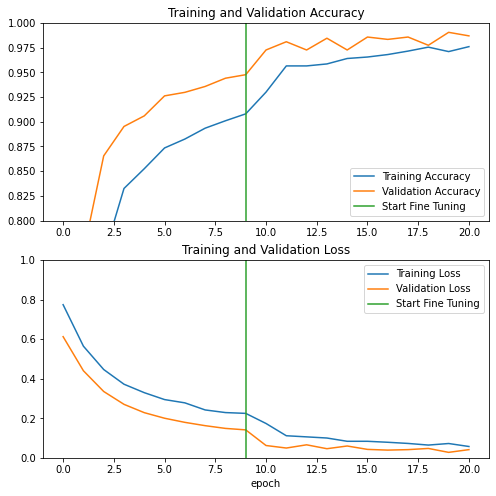

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and prediction

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 1s 48ms/step - loss: 0.0233 - accuracy: 0.9937
Test accuracy : 0.9937499761581421


# **Increase the number of layers**

In [ ]:

fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:

fine_tune_epochs = epochs + 10

history_fine = model.fit(train_dataset,
                         epochs=fine_tune_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


63/63 [==============================] - 16s 166ms/step - loss: 0.0229 - accuracy: 0.9890 - val_loss: 0.0363 - val_accuracy: 0.9833
Epoch 11/20
63/63 [==============================] - 8s 128ms/step - loss: 0.0224 - accuracy: 0.9930 - val_loss: 0.0292 - val_accuracy: 0.9845
Epoch 12/20
63/63 [==============================] - 9s 141ms/step - loss: 0.0219 - accuracy: 0.9895 - val_loss: 0.0425 - val_accuracy: 0.9821
Epoch 13/20
63/63 [==============================] - 9s 141ms/step - loss: 0.0266 - accuracy: 0.9895 - val_loss: 0.0341 - val_accuracy: 0.9833
Epoch 14/20
63/63 [==============================] - 8s 127ms/step - loss: 0.0235 - accuracy: 0.9915 - val_loss: 0.0417 - val_accuracy: 0.9821
Epoch 15/20
63/63 [==============================] - 8s 127ms/step - loss: 0.0183 - accuracy: 0.9915 - val_loss: 0.0376 - val_accuracy: 0.9833
Epoch 16/20
63/63 [==============================] - 9s 142ms/step - loss: 0.0272 - accuracy: 0.9885 - val_loss: 0.0304 - val_accuracy: 0.9845
Epoch 17/2

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy after increase layers to 150 :', accuracy)

5/5 [==============================] - 1s 41ms/step - loss: 0.0473 - accuracy: 0.9875
Test accuracy after increase layers to 150 : 0.987500011920929


# decrease the number of layers

In [ ]:
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = epochs + 10

history_fine = model.fit(train_dataset,
                         epochs=fine_tune_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


63/63 [==============================] - 17s 158ms/step - loss: 0.0201 - accuracy: 0.9935 - val_loss: 0.0401 - val_accuracy: 0.9833
Epoch 11/20
63/63 [==============================] - 9s 142ms/step - loss: 0.0251 - accuracy: 0.9915 - val_loss: 0.0351 - val_accuracy: 0.9833
Epoch 12/20
63/63 [==============================] - 8s 128ms/step - loss: 0.0226 - accuracy: 0.9930 - val_loss: 0.0371 - val_accuracy: 0.9821
Epoch 13/20
63/63 [==============================] - 9s 143ms/step - loss: 0.0204 - accuracy: 0.9925 - val_loss: 0.0333 - val_accuracy: 0.9845
Epoch 14/20
63/63 [==============================] - 10s 157ms/step - loss: 0.0201 - accuracy: 0.9935 - val_loss: 0.0284 - val_accuracy: 0.9845
Epoch 15/20
63/63 [==============================] - 9s 143ms/step - loss: 0.0306 - accuracy: 0.9900 - val_loss: 0.0406 - val_accuracy: 0.9821
Epoch 16/20
63/63 [==============================] - 8s 126ms/step - loss: 0.0285 - accuracy: 0.9910 - val_loss: 0.0373 - val_accuracy: 0.9833
Epoch 17/

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 1s 48ms/step - loss: 0.0025 - accuracy: 1.0000
Test accuracy : 1.0


# **prediction if pet is a cat or dog.**

Predictions:
 [0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0]
Labels:
 [0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0]


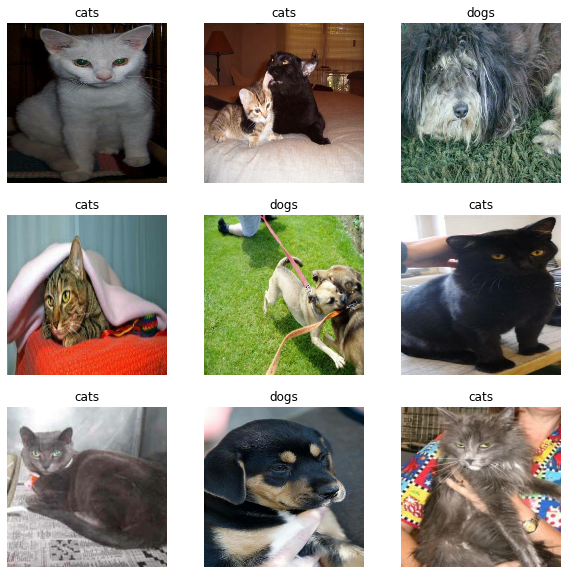

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

**After increase the layers the accuracy decrease and After decrease layers the accuracy increase**